In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",  # use whatever serif is available
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],  # fallback options
})

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
df = pd.read_csv('data/blocks.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y')
df = df.sort_values('DateTime').reset_index(drop=True)

halving_blocks = [210000, 420000, 630000, 840000]

actual_halvings = []
for hb in halving_blocks:
    row = df[df['Height'] >= hb].iloc[0]
    actual_halvings.append({'block': hb, 'date': row['DateTime']})

actual_df = pd.DataFrame(actual_halvings)

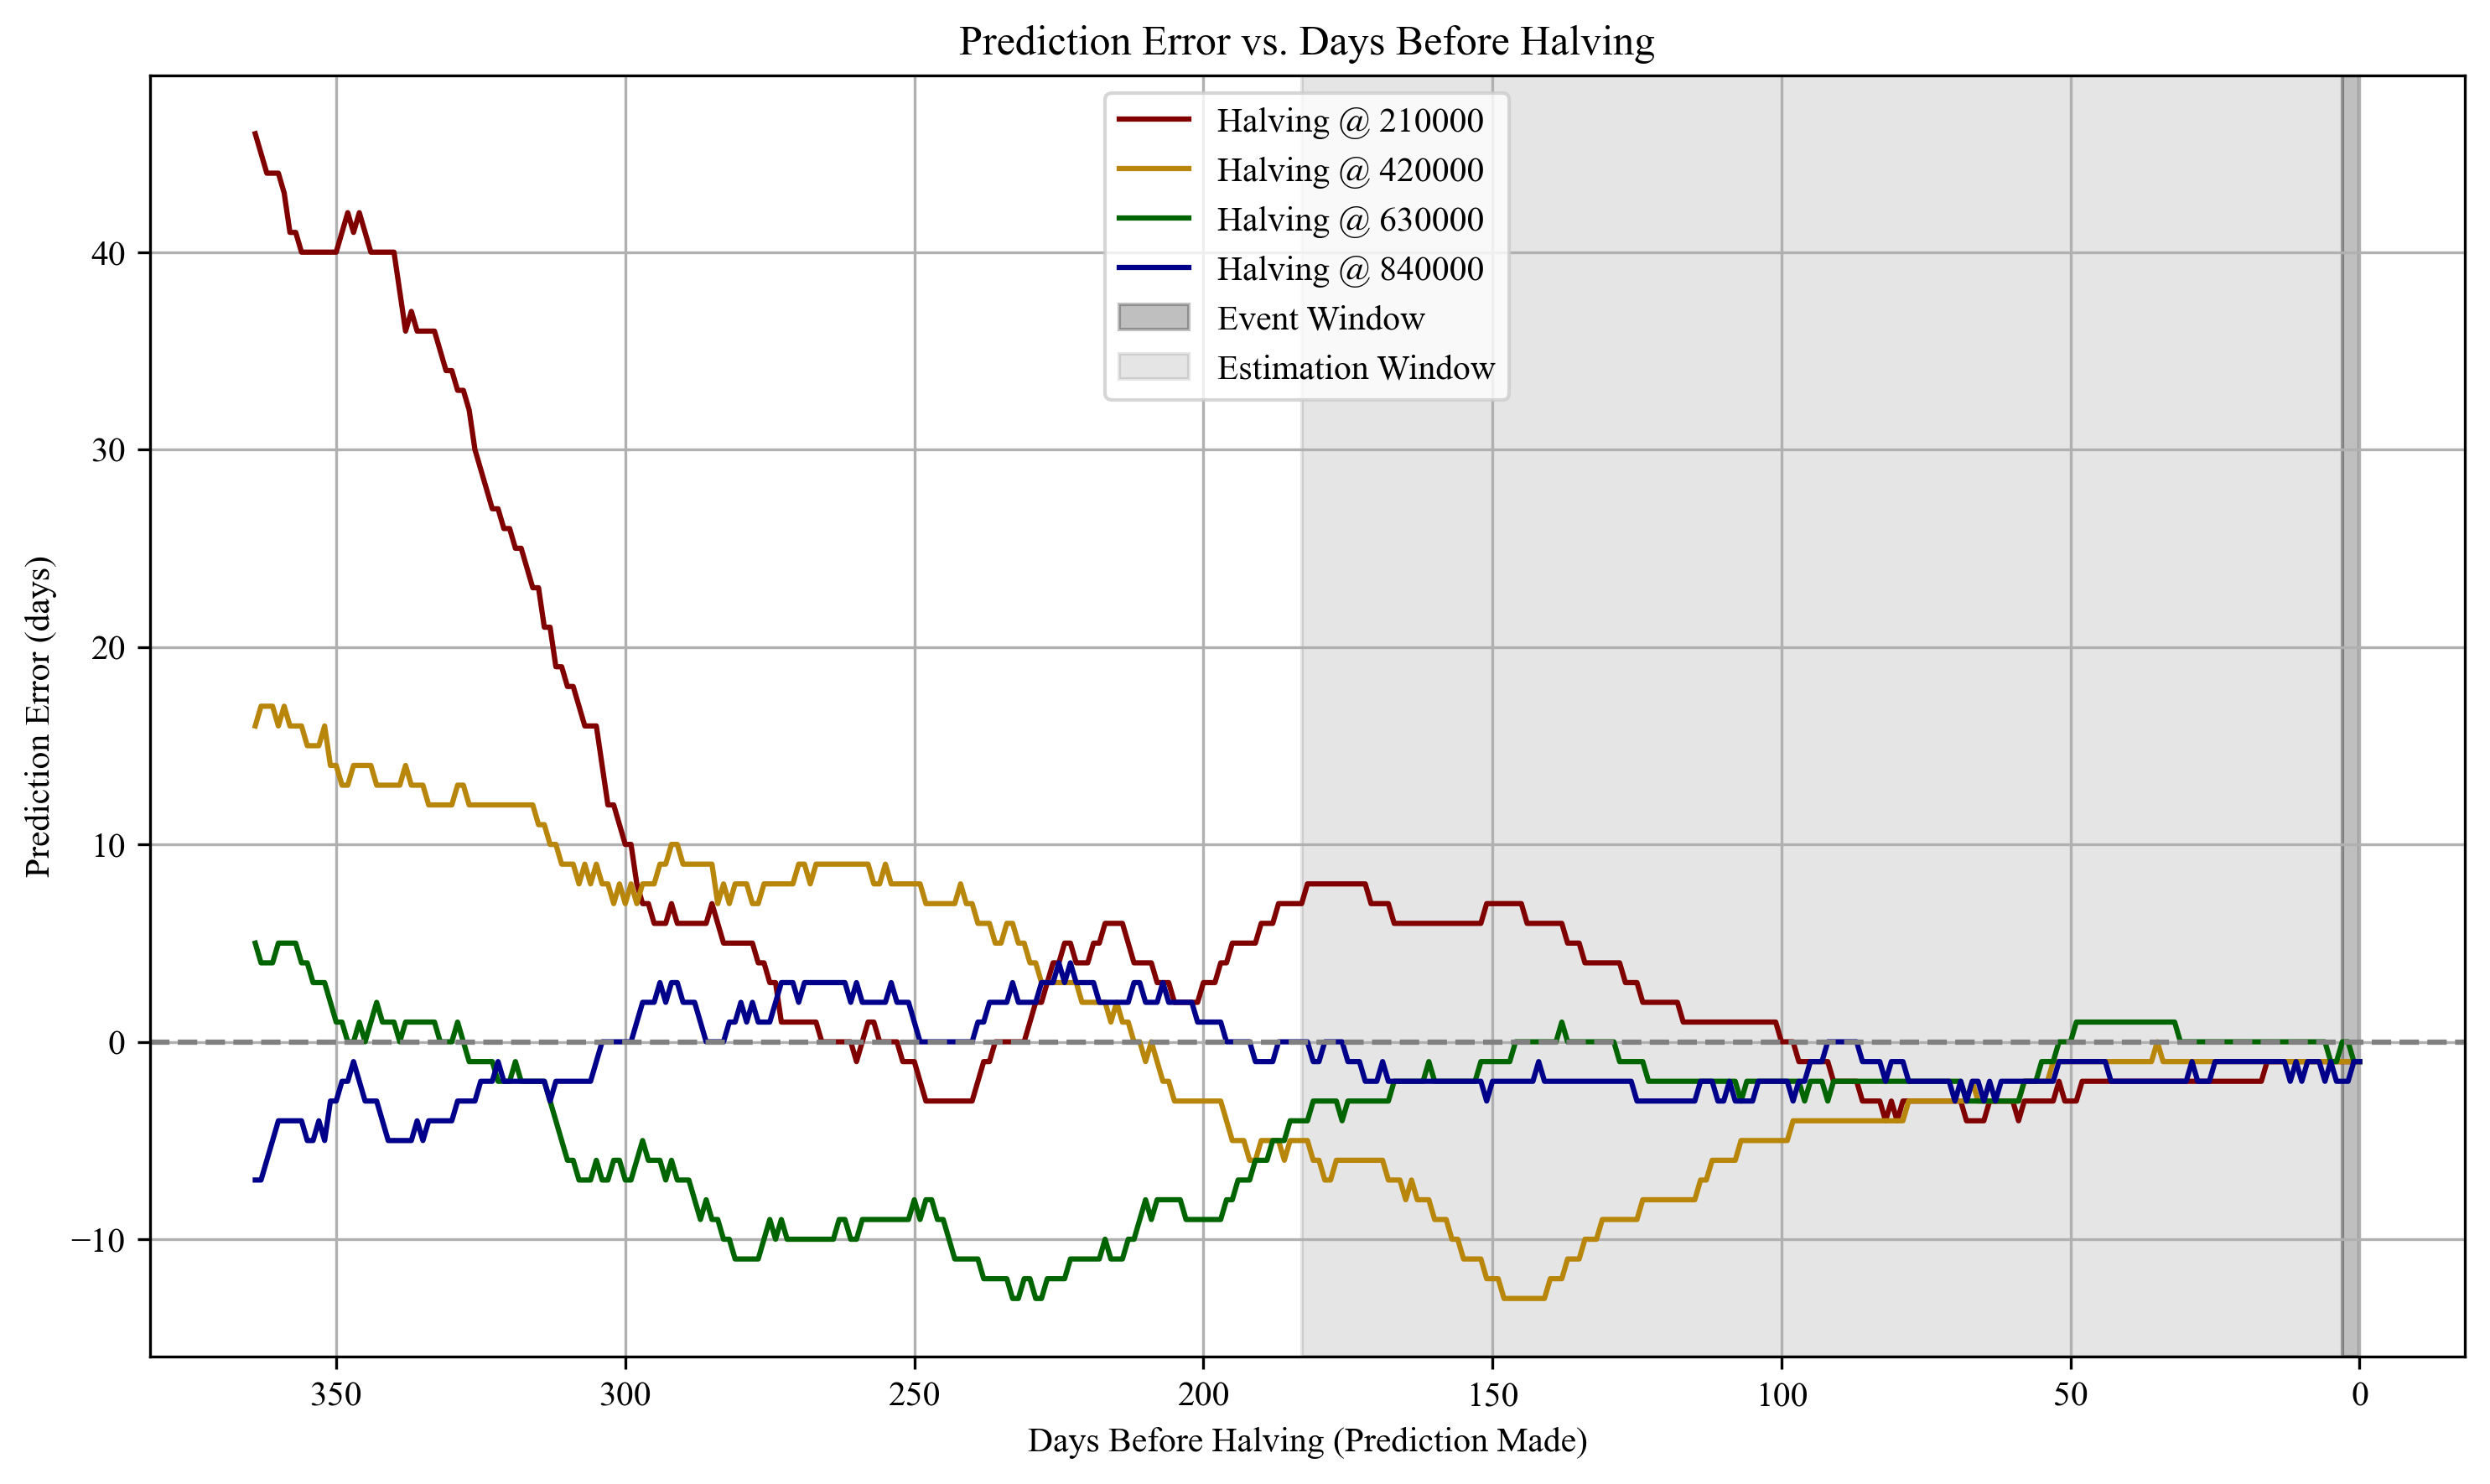

In [ ]:
# Different prediction windows (days before halving)
prediction_windows = range(365)
rolling_average = 100
results = []

for days_before in prediction_windows:
    for _, halving in actual_df.iterrows():
        cutoff_date = halving['date'] - pd.Timedelta(days=days_before)
        cutoff_df = df[df['DateTime'] <= cutoff_date].copy()

        # Use the last 7 days before cutoff for estimating block rate
        recent_window = cutoff_df.tail(rolling_average)
        avg_blocks_per_day = recent_window['Blocks Per Day'].mean()
        blocks_remaining = halving['block'] - cutoff_df['Height'].iloc[-1]
        predicted_days = blocks_remaining / avg_blocks_per_day
        predicted_date = cutoff_df['DateTime'].iloc[-1] + pd.Timedelta(days=predicted_days)
        error_days = (predicted_date.normalize() - halving['date']).days

        results.append({
            'prediction_window': days_before,
            'halving_block': halving['block'],
            'actual_date': halving['date'].date(),
            'predicted_date': predicted_date.normalize().date(),
            'error_days': error_days
        })

# Convert to DataFrame
error_df = pd.DataFrame(results)

# Define custom colors for each halving
colors = {
    210000: 'maroon',
    420000: 'darkgoldenrod',
    630000: 'darkgreen',
    840000: 'darkblue'
}

m = 3
n = 180

# Plot error vs. prediction window (lower absolute error is better)
plt.figure(figsize=(10, 6), dpi=300)
for block in halving_blocks:
    subset = error_df[error_df['halving_block'] == block]
    plt.plot(subset['prediction_window'], subset['error_days'],
             color=colors[block], label=f'Halving @ {block}')
    
# Event window: shade from m to 0 days before halving
plt.axvspan(m, 0, color="black", alpha=0.25, label="Event Window")
# Estimation window: shade from n to m+1 days before halving
plt.axvspan(n + m, m, color="black", alpha=0.1, label="Estimation Window")

plt.xlabel('Days Before Halving (Prediction Made)')
plt.ylabel('Prediction Error (days)')
plt.title('Prediction Error vs. Days Before Halving')
plt.axhline(0, color='gray', linestyle='--')
plt.gca().invert_xaxis()  # More recent predictions on the right
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()